In [1]:
import re
import subprocess
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
# %pip install pycirclize
from pycirclize import Circos
from pycirclize.parser import Genbank
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar

In [2]:
blin = 'genes.fasta'
subj = 'genomic.gbff'
newsubj = 'RKQQC_annotated_chr.fa'
failsubj = 'RKQQC_unknown_chr.fa'
blastout = 'RKQQC_blastn.out'

In [3]:
chrom_conv = {}

with open(subj, 'r') as f, open(newsubj, 'w') as fout, open(failsubj, 'w') as fail:
    for record in SeqIO.parse(f, 'genbank'):
        for feature in record.features:
            if 'chromosome' in feature.qualifiers:
                chrom_conv[record.id] = feature.qualifiers['chromosome'][0]
                fout.write(f'>{record.id} - Chromosome: {feature.qualifiers['chromosome'][0]} ({len(record.seq)} bp)\n')
                fout.write(str(record.seq) + '\n')
            elif 'chromosome' not in feature.qualifiers:
                fail.write(f'>{record.id} - Chromosome: Unknown\n')
                fail.write(str(record.seq) + '\n')

In [4]:
subprocess.run(['blastn', '-query', blin, '-subject', newsubj, '-outfmt', '6 qseqid sseqid pident bitscore sstart send sseq', '-out', blastout])

CompletedProcess(args=['blastn', '-query', 'genes.fasta', '-subject', 'RKQQC_annotated_chr.fa', '-outfmt', '6 qseqid sseqid pident bitscore sstart send sseq', '-out', 'RKQQC_blastn.out'], returncode=0)

Find the genes that brought back a good match from the BLAST search + create dictionary with location of each of the gene

In [5]:
gene_dict = {}

with open(blastout, 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        gene, chromID, pident, bitscore, sstart, send, sseq = line
        if chromID in chrom_conv:
            chrom = chrom_conv[chromID]
            if (int(float(bitscore)) > 1000) and (float(pident) > 95):
                if gene not in gene_dict:
                    gene_dict[gene] = [(chrom, int(sstart), int(send))]
                # Check for multiple entries of the same gene
                elif gene in gene_dict and (int(float(bitscore)) > 1000) and (float(pident) > 99) and (abs(int(sstart)-int(send)) > 600) and (chrom != gene_dict[gene][0][0]):
                    gene_dict[gene].append((chrom, int(sstart), int(send)))

In [6]:
tree_out = 'sampled_cds.csv'

with open(tree_out, 'r') as f:
    for line in f:
        line = line.strip().split(',')
        gene, snp_pb = line[8], line[11]
        # Only run this once, or re-initialise the gene_dict, otherwise you'll get multiple entries for snp_pb
        if gene in gene_dict:
                gene_dict[gene] = [gene_dict[gene] + (float(snp_pb),) for gene_dict[gene] in gene_dict[gene]]
        else:
            continue


In [7]:

snp_matrix = []

for gene, entries in gene_dict.items():
    for chrom, start, end, snp in entries:
        if gene not in snp_matrix:
            snp_matrix.append([gene, chrom, start, end, snp])

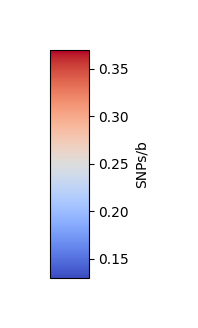

In [8]:
spectral = plt.get_cmap('coolwarm', 256)
norm = mcolors.Normalize(vmin=min([x[4] for x in snp_matrix]), vmax=max([x[4] for x in snp_matrix]))

fig, ax = plt.subplots(figsize=(0.5, 6))
fig.subplots_adjust(bottom=0.5)

cmap = spectral
cb = mcolorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')

cb.set_label('SNPs/b')

plt.savefig('RKQQC_legend_heatmap_cw.svg')

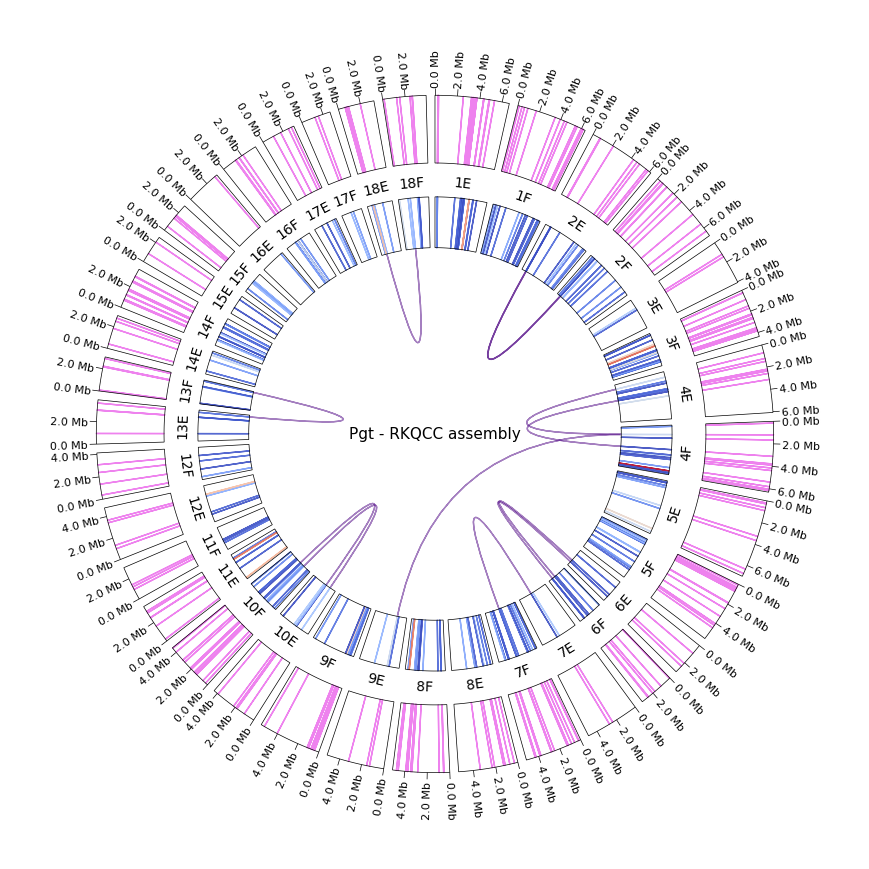

In [9]:
gbk = Genbank(subj)
chr_sectors = {feature.qualifiers['chromosome'][0]: len(record.seq) for record in gbk.records for feature in record.features if 'chromosome' in feature.qualifiers}
circos = Circos(sectors=chr_sectors, space=1.5)
circos.text(f'Pgt - RKQCC assembly', size=11)

# Keep track of genes with multiple entries
gene_positions = {}

for sector in circos.sectors:
    sector.text(f'{sector.name}', r=72.5, rotation=90, size=10, ha='center', va='center', color='black')
    geneloc_track = sector.add_track((80, 100), r_pad_ratio=0)
    geneloc_track.xticks_by_interval(interval=2000000, label_orientation='vertical', label_formatter=lambda v: f"{v / 1000000:.1f} Mb")
    geneloc_track.axis()
    heatmap_track = sector.add_track((55, 70), r_pad_ratio=0)
    heatmap_track.axis()
    for gene, entries in gene_dict.items():
        for chrom, sstart, send, snp_pb in entries:
            color = spectral(norm(float(snp_pb)))
            if chrom == sector.name:
                geneloc_track.rect(sstart, send, color='violet', lw=1)
                heatmap_track.rect(sstart, send, color=color, lw=1, alpha=0.9)
                # Store the gene positions
                if gene in gene_positions:
                    gene_positions[gene].append((sector.name, sstart, send))
                else:
                    gene_positions[gene] = [(sector.name, sstart, send)]

# Add links for genes with multiple entries
for gene, positions in gene_positions.items():
    if len(positions) > 1:
        for i in range(len(positions) - 1):
            # Each position is a tuple (sector, start, end)
            circos.link(positions[i], positions[i+1], color='indigo', lw=1)

circos.plotfig()
circos.savefig('RKQQC_circos_heatmap_links.svg')